In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime

path_ru = './avito_data/all_russia' 
path_msk = './avito_data/msk' 

files_ru = Path(path_ru).glob('*.csv')  
files_msk = Path(path_msk).glob('*.csv')  

In [4]:
dfs_ru = list()
for f in files_ru:
    data = pd.read_csv(f)
    dfs_ru.append(data)

df_original_ru = pd.concat(dfs_ru, ignore_index=True)
df_original_ru = df_original_ru[df_original_ru['Расстояние от МКАД'].isna()]
df_original_ru = df_original_ru[(df_original_ru['Область'] != 'Московская обл.') & 
                                (df_original_ru['Город'] != 'г. Москва')]

dfs_msk = list()
for f in files_msk:
    data = pd.read_csv(f)
    dfs_msk.append(data)

df_original_msk = pd.concat(dfs_msk, ignore_index=True)

In [5]:
import re
def process_prices(df):            
    # Гипотеза, что у продвигаемых объявлений нереалистичная цена - уменьшаем ее на 5%
    df['Цена'] = np.where(df['Продвижения'].notna(), 
                              df['Цена'] * 0.95, 
                              df['Цена'])
    # Логарифмируем цену чтобы сгладить выбросы
    df = df.assign(log_price=np.log1p(df['Цена']))
    df = df.drop(['Продвижения'], axis=1)
    # Убираем выбросы
    top_quantile = df['log_price'].quantile(0.975)
    low_quantile = df['log_price'].quantile(0.025)
    return df[(df['log_price']>low_quantile)&(df['log_price']<top_quantile)]

def remove_unused(df):    
    # Оставляем только нужные колонки и оставляем только ижс  
    df = df.drop(['Пр.Всего', 'Пр.Сегод.', 'Кол-во знак.', 'Цена', 'Цена м²', 'ОбщПлощ', 'Отделка', 'Ссылка',
                'Фото шт.', 'Фото', 'Unnamed: 50', 'Unnamed: 51', 'Продавец', 'Этаж', 'Ссылка', 'Широта',  'Долгота',
                'Unnamed: 52', 'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55', 'Метро1', 'Метро2', 'Метро3', 'Улица', 
                'Район', 'Поселок', 'Мкр-н','Гор.Округ',
                'Unnamed: 56', 'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59',
                'Unnamed: 60', 'Unnamed: 61', 'Unnamed: 62', 'Unnamed: 63',
                'Unnamed: 64', 'Unnamed: 65', 'Unnamed: 66', 'Unnamed: 67',
                'Unnamed: 68', 'Unnamed: 69', 'Unnamed: 70', 'Unnamed: 71',
                'Unnamed: 72', 'Unnamed: 73', 'Unnamed: 74', 'Unnamed: 75',
                'Unnamed: 76', 'Unnamed: 77', 'Unnamed: 78', 'Unnamed: 79',
                'Unnamed: 80', 'Unnamed: 81', 'Unnamed: 82', 'Unnamed: 83',
                'Unnamed: 84', 'Unnamed: 85', 'Unnamed: 86', 'Unnamed: 87', 'Unnamed: 48',
                'Unnamed: 88', 'Unnamed: 89', 'Unnamed: 90', 'Время поднятия',
                'Unnamed: 49', 'Unnamed: 91', 'Unnamed: 92', 'Позиция', 'Пониж.цена', '№ объяв.',
                'Unnamed: 93'], axis=1, errors='ignore')
    categories_to_keep = ['Дома', 'Коттеджи', 'Таунхаусы']
    df = df[df['Подкатегория'].isin(categories_to_keep)]
    df = df.drop(['Подкатегория'], axis=1)
    category = ['индивидуальное жилищное строительство (ИЖС)']
    df = df[df['Категория земель'].isin(category)]
    return df.drop(['Категория земель'], axis=1)

def extract_number(value):
    if pd.isna(value):
        return np.nan
    match = re.search(r'\d+(?:\.\d+)?', str(value))
    if match:
        return float(match.group())
    return np.nan

def encode_as_float(df, columns):
    for col in columns:
        df[col] = df[col].apply(extract_number)
    df = df.dropna(subset=columns)
    return df

def encode_toilet(df):
    def _encode(value):
        if pd.isna(value):
            return np.nan
        elif 'на улице' in str(value).lower() and 'в доме' in str(value).lower():
            return 2
        elif 'в доме' in str(value).lower():
            return 1
        elif 'на улице' in str(value).lower():
            return 0
        else:
            return np.nan

    df['Санузел'] = df['Санузел'].apply(_encode)
    return df.dropna(subset=['Санузел'])

def encode_city_center_distance(df):
    def _encode(distance):
        if pd.isna(distance):
            return 'Нет данных'
        if distance < 17:
            return 'Близко к городу'
        else:
            return 'Далеко от города'
    
    df['Расстояние до центра города'] = df['Расстояние до центра города'].apply(extract_number).astype(float)
    df['Расстояние_до_центра_города'] = df['Расстояние до центра города'].apply(_encode)
    df = pd.get_dummies(df, columns=['Расстояние_до_центра_города'], prefix='Расст_центр', dtype=int)
    return df.drop('Расстояние до центра города', axis=1)

def encode_amenities(df):
    def _encode(row):
        description = str(row['Описание']).lower()
        for_leisure = str(row['Для отдыха']).lower() if pd.notna(row['Для отдыха']) else ''
        
        has_banya = 1 if ('баня' in description or 'баня' in for_leisure or 'сауна' in description or 'сауна' in for_leisure) else 0
        has_pool = 1 if ('бассейн' in description or 'бассейн' in for_leisure) else 0
        
        return pd.Series({'Есть_баня': has_banya, 'Есть_бассейн': has_pool})
    
    df[['Есть_баня', 'Есть_бассейн']] = df.apply(_encode, axis=1)
    return df.drop('Для отдыха', axis=1, errors='ignore')

def encode_infrastructure(df):
    def _encode(row):
        description = str(row['Описание']).lower()
        infrastructure = str(row['Инфраструктура']).lower() if pd.notna(row['Инфраструктура']) else ''
        
        has_shop = 1 if ('магазин' in description or 'магазин' in infrastructure) else 0
        has_pharmacy = 1 if ('аптек' in description or 'аптека' in infrastructure) else 0
        has_kindergarten = 1 if ('детский сад' in description or 'детский сад' in infrastructure) else 0
        has_school = 1 if ('школ' in description or 'школа' in infrastructure) else 0
        
        return pd.Series({'Есть_магазин': has_shop, 'Есть_аптека': has_pharmacy, 'Есть_детский_сад': has_kindergarten, 'Есть_школа': has_school})
    
    df[['Есть_магазин', 'Есть_аптека', 'Есть_детский_сад', 'Есть_школа']] = df.apply(_encode, axis=1)
    return df.drop('Инфраструктура', axis=1, errors='ignore')

def encode_tv_wifi(df):
    def _encode(row):
        description = str(row['Описание']).lower()
        tv_wifi = str(row['Интернет/ТВ']).lower() if pd.notna(row['Интернет/ТВ']) else ''
        
        has_tv = 1 if ('телевидение' in description or 'телевидение' in tv_wifi) else 0
        has_wifi = 1 if ('wi-fi' in description or 'wi-fi' in tv_wifi or 'интернет' in description or 'вайфай' in description) else 0
        
        return pd.Series({'Есть_wifi': has_wifi, 'Есть_tv': has_tv})
    
    df[['Есть_wifi', 'Есть_tv']] = df.apply(_encode, axis=1)
    return df.drop('Интернет/ТВ', axis=1, errors='ignore')

def encode_rooms(df):
    def _encode(value):
        if value == 'Свободная планировка':
            return np.nan
        elif value == '10 и больше':
            return 10.0
        else:
            try:
                return float(value)
            except ValueError:
                return np.nan
    
    df['Кол-воКомн_encoded'] = df['Кол-воКомн'].apply(_encode)
    df['Свободная_планировка'] = (df['Кол-воКомн'] == 'Свободная планировка').astype(int)
    median_rooms = df['Кол-воКомн_encoded'].median()
    df['Кол-воКомн_encoded'].fillna(median_rooms, inplace=True)
    return df.drop('Кол-воКомн', axis=1)

def encode_repair(df):
    df = df.dropna(subset=['Ремонт'])
    repair_dummies = pd.get_dummies(df['Ремонт'], prefix='Ремонт')
    df = pd.concat([df, repair_dummies], axis=1)
    return df.drop('Ремонт', axis=1)

def encode_wall_material(df):
    df = df[df['МатериалСтен'].notna()]
    mean_target = df.groupby('МатериалСтен')['log_price'].mean()
    df['МатериалСтен'] = df['МатериалСтен'].map(mean_target)
    return df

def encode_parking(df):
    def _encode(row):
        description = str(row['Описание']).lower()
        parking = str(row['Парковка']).lower() if pd.notna(row['Парковка']) else ''
        
        has_parking = 1 if ('парковочное' in description or 'парковочное' in parking or 'парковк' in description) else 0
        has_garage = 1 if ('гараж' in description or 'гараж' in parking) else 0
        
        return pd.Series({'Есть_парковка': has_parking, 'Есть_гараж': has_garage})
    
    df[['Есть_парковка', 'Есть_гараж']] = df.apply(_encode, axis=1)
    return df.drop('Парковка', axis=1, errors='ignore')

def encode_mortgage(df):
    def _encode(row):
        mortgage = str(row['Способ продажи']).lower() if pd.notna(row['Способ продажи']) else ''
        mortgage_available = 1 if ('возможна ипотека' in mortgage) else 0
        return pd.Series({'Возможна_ипотека': mortgage_available})
    
    df[['Возможна_ипотека']] = df.apply(_encode, axis=1)
    return df.drop('Способ продажи', axis=1, errors='ignore')

def encode_terrace(df):
    def _encode(row):
        description = str(row['Описание']).lower()
        terrace = str(row['Терраса или веранда']).lower() if pd.notna(row['Терраса или веранда']) else ''
        
        has_terrace = 1 if ('веранд' in description or 'есть' in terrace or 'террас' in description or 'балкон' in description) else 0
        return pd.Series({'Есть_терраса': has_terrace})
    
    df[['Есть_терраса']] = df.apply(_encode, axis=1)
    return df.drop('Терраса или веранда', axis=1, errors='ignore')

def encode_transport(df):
    def _encode(row):
        description = str(row['Описание']).lower()
        transport = str(row['Транспортная доступность']).lower() if pd.notna(row['Транспортная доступность']) else ''
        
        asphalt = 1 if ('асфальтированная дорога' in transport or 'асфальт' in description) else 0
        public_transport = 1 if ('остановка общественного транспорта' in transport or 
                                 'автобус' in description or 
                                 'маршрутка' in description or 
                                 'общественный транспорт' in description) else 0
        railway = 1 if ('железнодорожная станция' in transport or 
                        'жд' in description or 
                        'железнодорожная' in description or 
                        'электричка' in description) else 0
        
        return pd.Series({
            'Есть_асфальт': asphalt, 
            'Есть_общ_транспорт': public_transport, 
            'Есть_жд': railway
        })
    
    df[['Есть_асфальт', 'Есть_общ_транспорт', 'Есть_жд']] = df.apply(_encode, axis=1)
    return df.drop('Транспортная доступность', axis=1, errors='ignore')

def process_year(df):
    current_year = datetime.now().year
    
    def calculate_age(year):
        if pd.isna(year):
            return np.nan
        try:
            age = current_year - int(float(year))
            return max(0, age)  # Ensure age is not negative
        except ValueError:
            return np.nan
    
    df['ВозрастДома'] = df['ГодПостр'].apply(calculate_age)
    df['ВозрастДома'] = df['ВозрастДома'].fillna(df['ВозрастДома'].median())
    
    # Add non-linear age feature
    df['ВозрастДома_Squared'] = df['ВозрастДома'] ** 2
    
    # Add categorical age feature
    def categorize_age(age):
        if age < 5:
            return 'New (0-5 years)'
        elif age < 10:
            return 'Recent (5-10 years)'
        elif age < 20:
            return 'Modern (10-20 years)'
        elif age < 40:
            return 'Established (20-40 years)'
        else:
            return 'Old (40+ years)'
    
    df['ВозрастКатегория'] = df['ВозрастДома'].apply(categorize_age)
    df = pd.get_dummies(df, columns=['ВозрастКатегория'], prefix='Возраст', dtype=int)
    
    # Add boolean feature for very new buildings
    df['Новостройка'] = (df['ВозрастДома'] <= 5).astype(int)
    
    return df.drop('ГодПостр', axis=1)

def encode_utilities(df):
    def _encode(row):
        description = str(row['Описание']).lower()
        utils = str(row['Коммуникации']).lower() if pd.notna(row['Коммуникации']) else ''
        
        has_elec = 1 if ('электрич' in description or 'электричество' in utils) else 0
        has_heat = 1 if ('отопление' in description or 'отопление' in utils) else 0
        has_gas = 1 if ('газ' in description or 'газ' in utils) else 0
        has_sew = 1 if ('канализац' in description or 'канализация' in utils) else 0

        return pd.Series({'Есть_электричество': has_elec, 'Есть_отопление': has_heat, 'Есть_газ': has_gas, 'Есть_канализация': has_sew})

    df[['Есть_электричество', 'Есть_газ', 'Есть_отопление', 'Есть_канализация']] = df.apply(_encode, axis=1)
    return df.drop('Коммуникации', axis=1, errors='ignore')

def add_region(df):
    def get_region(row):
        if pd.notna(row['Область']):
            return row['Область']
        elif pd.notna(row['Край']):
            return row['Край']
        elif pd.notna(row['Адрес']):
            region = row['Адрес'].split(',')[0].strip()
            if "р-н" in region:
                return row['Город']
            return region
        else:
            return row['Город']
    
    df['Регион'] = df.apply(get_region, axis=1)
    
    # Count the occurrences of each region
    region_counts = df['Регион'].value_counts()
    
    regions_to_keep = region_counts[region_counts >= 10].index
    
    df = df.drop(['Область', 'Край', 'Адрес'], axis=1)
    df = df[df['Регион'].isin(regions_to_keep)]
    df = df[df['Регион'].isin(regions_to_keep)]
    return df.dropna(subset=['Регион'])

def normalize_region_name(name):
    # Обновленный словарь для замены сокращений и стандартизации названий
    replacements = {
        'обл.': 'область',
        'АО': 'автономный округ',
        'Респ.': 'Республика',
        'г.': 'город',
        'г.о.': 'городской округ',
        'автономный округ': 'АО',
        'город ': '',  # Убираем слово "город" перед названиями городов
        'в том числе ': '',  # Убираем фразу "в том числе"
        ' без авт. округа': '',  # Убираем фразу "без авт. округа"
        'Уфа': 'Республика Башкортостан',
        'Казань': 'Республика Татарстан',
        'Махачкала': 'Республика Дагестан',
        'Мамадышский тракт': 'Республика Татарстан',
        'Ижевск': 'Удмуртская Республика',
        'Улан-Удэ': 'Республика Бурятия',
        "Владикавказ": "Республика Северная Осетия - Алания",
        "Нальчик": "Кабардино-Балкарская Республика",
        "Чебоксары": "Чувашская Республика",
        "Набережные Челны": "Республика Татарстан",
        "Петрозаводск": "Республика Карелия",
        "Семендер": "Республика Дагестан",
        "Ленинкент": "Республика Дагестан",
        "Стерлитамак": "Республика Башкортостан",
        "Беслан": "Республика Северная Осетия - Алания",
        "Моздок": "Республика Северная Осетия - Алания",
        "Саранск": "Республика Мордовия",
        "Алагир": "Республика Северная Осетия - Алания",
        "Гизель": "Республика Северная Осетия - Алания",
        "Архонская": "Республика Северная Осетия - Алания",
        "Новый Хушет": "Республика Дагестан",
        "Ардон": "Республика Северная Осетия - Алания",
        "Красносельское шоссе": "г.Санкт-Петербург",
        "Московское шоссе": "г.Санкт-Петербург", 
        "Горское шоссе": "Республика Северная Осетия - Алания",  
        "Волхонское шоссе": "г.Санкт-Петербург",
        "Новосибирский район": "Новосибирская область",
    }
    
    # Замена сокращений
    for old, new in replacements.items():
        name = name.replace(old, new)
    
    # Удаление лишних пробелов
    name = re.sub(r'\s+', ' ', name).strip()
    
    # Особые случаи
    if "Санкт-Петербург" in name:
        return "г.Санкт-Петербург"
    if "Москва" in name:
        return "г.Москва"
    
    if "Осетия" in name:
        return "Республика Северная Осетия - Алания"
    
    return name
    
def add_district_and_salary(df):
    df_salary_data = pd.read_csv('./additional_data/salary_region.csv')
    
    # Нормализация названий регионов в обоих DataFrame
    df['Регион'] = df['Регион'].apply(normalize_region_name)
    df_salary_data['Регион'] = df_salary_data['Регион'].apply(normalize_region_name)
    
    # Создание словарей для маппинга
    okrug = dict(zip(df_salary_data['Регион'], df_salary_data['Округ']))
    salary = dict(zip(df_salary_data['Регион'], df_salary_data['ЗП']))
    
    # Маппинг данных
    df['Округ'] = df['Регион'].map(okrug)
    df['ЗП'] = df['Регион'].map(salary)
    
    df = df.dropna(subset=['ЗП'])
    return df

def add_population(df):
    def normalize_string(s):
        if pd.isna(s):
            return s
        s = s.lower()
        s = re.sub(r'[^a-zа-я0-9\s]', '', s)
        s = re.sub(r'\s+', ' ', s)
        return s.strip()
    
    population_data = pd.read_csv('./additional_data/city_population.csv')
    population_data = population_data.rename(columns={
        "key": "Город",
        "population": "Население"
    })

    df["Город"] =  df["Город"].apply(normalize_string) + ' ' + df["Регион"].apply(normalize_string) if 'Регион' in df.columns else df["Город"].apply(normalize_string) + ' ' + 'московская область' 

    merged_df = df.merge(population_data[['Город', 'Население']], 
                        on=["Город"], 
                        how="left")

    merged_df['Население'] = merged_df['Население'].fillna(0)

    return df

def remove_outliers(df, columns):
    """
    Remove outliers from specified columns using the IQR method.
    
    :param df: DataFrame
    :param columns: List of column names to remove outliers from
    :return: DataFrame with outliers removed
    """
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

def process_floors(df):
    df['Кол-воЭтаж'] = df['Кол-воЭтаж'].apply(extract_number)
    
    # Fill NaN values with the median
    median_floors = df['Кол-воЭтаж'].median()
    df['Кол-воЭтаж'] = df['Кол-воЭтаж'].fillna(median_floors)
    
    return df


In [6]:
df_working_ru = df_original_ru.copy()
df_working_msk = df_original_msk.copy()

df_working_ru = process_prices(df_working_ru)
df_working_msk = process_prices(df_working_msk)
df_working_ru = remove_unused(df_working_ru)
df_working_msk = remove_unused(df_working_msk)

columns_to_encode_ru = ['Площ.дома', 'Площ.Участка']
columns_to_encode_msk = ['Площ.дома', 'Площ.Участка', 'Расстояние от МКАД']
df_working_ru = encode_as_float(df_working_ru, columns_to_encode_ru)
df_working_msk = encode_as_float(df_working_msk, columns_to_encode_msk)

df_working_ru = remove_outliers(df_working_ru, columns_to_encode_ru)
df_working_msk = remove_outliers(df_working_msk, columns_to_encode_msk)

df_working_ru = encode_toilet(df_working_ru)
df_working_msk = encode_toilet(df_working_msk)

df_working_ru = encode_city_center_distance(df_working_ru)

def process_dataframe(df):
    df = encode_amenities(df)
    df = encode_infrastructure(df)
    df = encode_tv_wifi(df)
    df = encode_rooms(df)
    df = encode_repair(df)
    df = encode_wall_material(df)
    df = encode_parking(df)
    df = encode_mortgage(df)
    df = encode_terrace(df)
    df = encode_transport(df)
    df = process_year(df)
    df = encode_utilities(df)
    df = process_floors(df)
    return df

df_working_ru = process_dataframe(df_working_ru)
df_working_msk = process_dataframe(df_working_msk)

df_working_ru = add_region(df_working_ru)
df_working_ru = add_district_and_salary(df_working_ru)
df_working_ru = add_population(df_working_ru)

df_working_ru = df_working_ru.drop(['Описание', 'Заголовок', 'Расстояние от МКАД'], axis=1)
df_working_msk = df_working_msk.drop(['Описание', 'Заголовок', 'Адрес', 'Область'], axis=1)

In [8]:
# Обучим модель для RU

from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split

train_ru, test_ru = train_test_split(df_working_ru, test_size=0.2, random_state=42)

autogluon_automl_ru = TabularPredictor(label='log_price', problem_type='regression', eval_metric='mean_squared_error', verbosity=0)

autogluon_automl_ru.fit(train_data=train_ru)

autogluon_automl_ru.evaluate(test_ru)

{'mean_squared_error': -0.09949024962594712,
 'root_mean_squared_error': -0.3154207501512022,
 'mean_absolute_error': -0.23408384980058228,
 'r2': 0.6963582122133705,
 'pearsonr': 0.8346331510988094,
 'median_absolute_error': -0.17473978899682407}

In [9]:
# Анализ метрик RU

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Получаем предсказания на тестовом наборе
y_pred_ru = autogluon_automl_ru.predict(test_ru)
y_true_ru = test_ru['log_price']

# Рассчитываем метрики
mse = mean_squared_error(y_true_ru, y_pred_ru)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_ru, y_pred_ru)

print("Метрики качества:")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Рассчитываем ошибку в рублях
y_true_exp_ru = np.expm1(y_true_ru)
y_pred_exp_ru = np.expm1(y_pred_ru)

mae_rub = mean_absolute_error(y_true_exp_ru, y_pred_exp_ru)

print(f"\nСредняя абсолютная ошибка в рублях: {mae_rub:,.2f}")

# Рассчитываем процентную ошибку
mape = np.mean(np.abs((y_true_exp_ru - y_pred_exp_ru) / y_true_exp_ru)) * 100

print(f"\nСредняя абсолютная процентная ошибка (MAPE): {mape:.2f}%")

Метрики качества:
RMSE: 0.3154
R2: 0.6964

Средняя абсолютная ошибка в рублях: 2,520,502.39

Средняя абсолютная процентная ошибка (MAPE): 24.49%


In [10]:
from sklearn.model_selection import train_test_split

train_msk, test_msk = train_test_split(df_working_msk, test_size=0.2, random_state=42)

autogluon_automl_msk = TabularPredictor(label='log_price', problem_type='regression', eval_metric='mean_squared_error', verbosity=0)

autogluon_automl_msk.fit(train_data=train_msk)

autogluon_automl_msk.evaluate(test_msk)

{'mean_squared_error': -0.05659277045078354,
 'root_mean_squared_error': -0.2378923505512179,
 'mean_absolute_error': -0.17527901168572563,
 'r2': 0.7818955545932252,
 'pearsonr': 0.885900328664674,
 'median_absolute_error': -0.12400824226049778}

In [11]:
# Анализ метрик MSK

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Получаем предсказания на тестовом наборе
y_pred_msk = autogluon_automl_msk.predict(test_msk)
y_true_msk = test_msk['log_price']

# Рассчитываем метрики
mse = mean_squared_error(y_true_msk, y_pred_msk)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_msk, y_pred_msk)

print("Метрики качества:")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Рассчитываем ошибку в рублях
y_true_exp_msk = np.expm1(y_true_msk)
y_pred_exp_msk = np.expm1(y_pred_msk)

mae_rub = mean_absolute_error(y_true_exp_msk, y_pred_exp_msk)

print(f"\nСредняя абсолютная ошибка в рублях: {mae_rub:,.2f}")

# Рассчитываем процентную ошибку
mape = np.mean(np.abs((y_true_exp_msk - y_pred_exp_msk) / y_true_exp_msk)) * 100

print(f"\nСредняя абсолютная процентная ошибка (MAPE): {mape:.2f}%")

Метрики качества:
RMSE: 0.2379
R2: 0.7819

Средняя абсолютная ошибка в рублях: 2,174,677.74

Средняя абсолютная процентная ошибка (MAPE): 17.87%


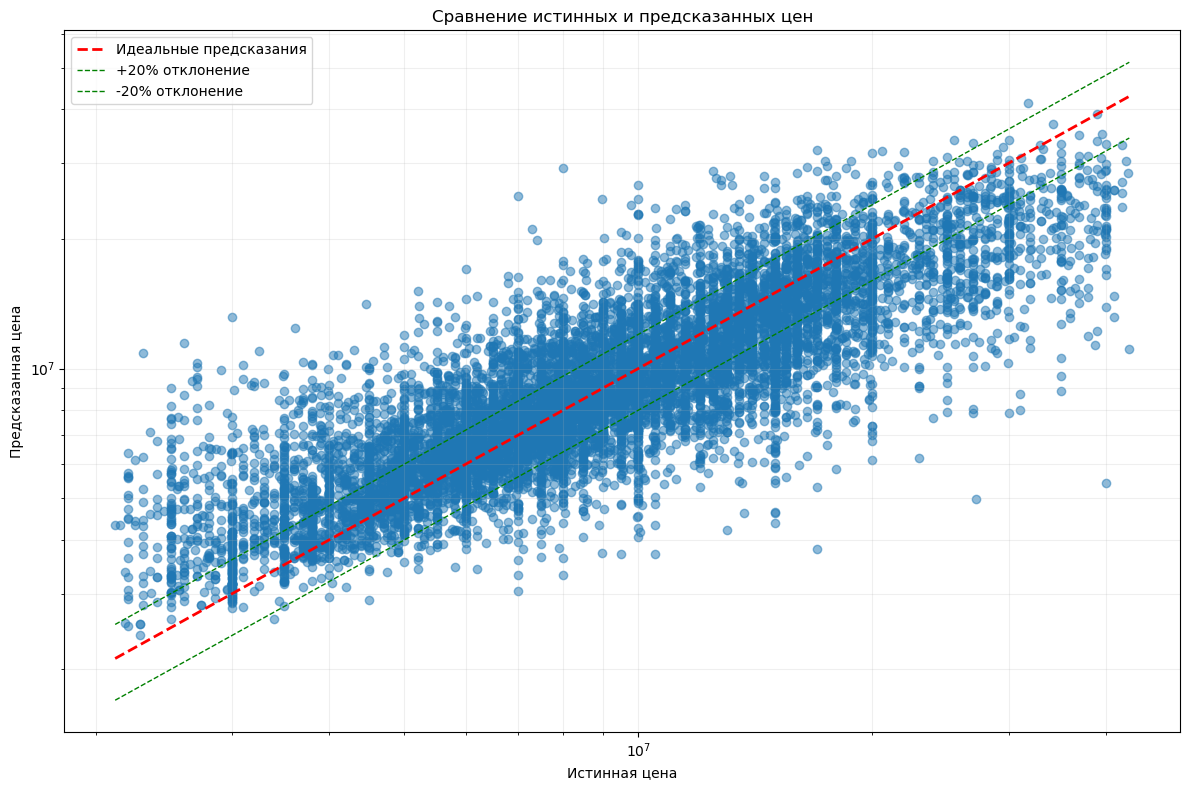

In [12]:
# Линия идеальных предсказаний RU
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))

# Основной график
plt.scatter(y_true_exp_ru, y_pred_exp_ru, alpha=0.5)

# Линия идеальных предсказаний
min_val = min(y_true_exp_ru.min(), y_pred_exp_ru.min())
max_val = max(y_true_exp_ru.max(), y_pred_exp_ru.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Идеальные предсказания')

# Линии отклонения на 20%
plt.plot([min_val, max_val], [min_val*1.2, max_val*1.2], 'g--', lw=1, label='+20% отклонение')
plt.plot([min_val, max_val], [min_val*0.8, max_val*0.8], 'g--', lw=1, label='-20% отклонение')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Истинная цена")
plt.ylabel("Предсказанная цена")
plt.title("Сравнение истинных и предсказанных цен")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

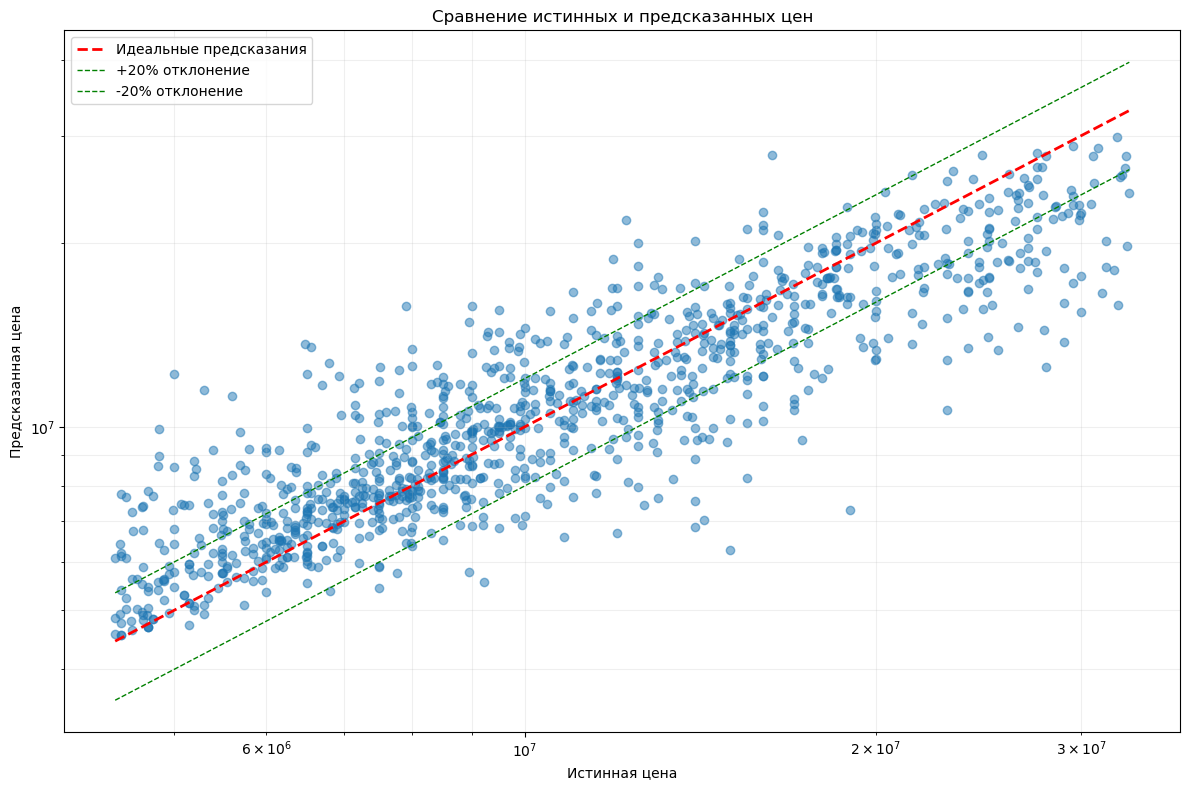

In [13]:
# Линия идеальных предсказаний MSK
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))

# Основной график
plt.scatter(y_true_exp_msk, y_pred_exp_msk, alpha=0.5)

# Линия идеальных предсказаний
min_val = min(y_true_exp_msk.min(), y_pred_exp_msk.min())
max_val = max(y_true_exp_msk.max(), y_pred_exp_msk.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Идеальные предсказания')

# Линии отклонения на 20%
plt.plot([min_val, max_val], [min_val*1.2, max_val*1.2], 'g--', lw=1, label='+20% отклонение')
plt.plot([min_val, max_val], [min_val*0.8, max_val*0.8], 'g--', lw=1, label='-20% отклонение')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("Истинная цена")
plt.ylabel("Предсказанная цена")
plt.title("Сравнение истинных и предсказанных цен")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

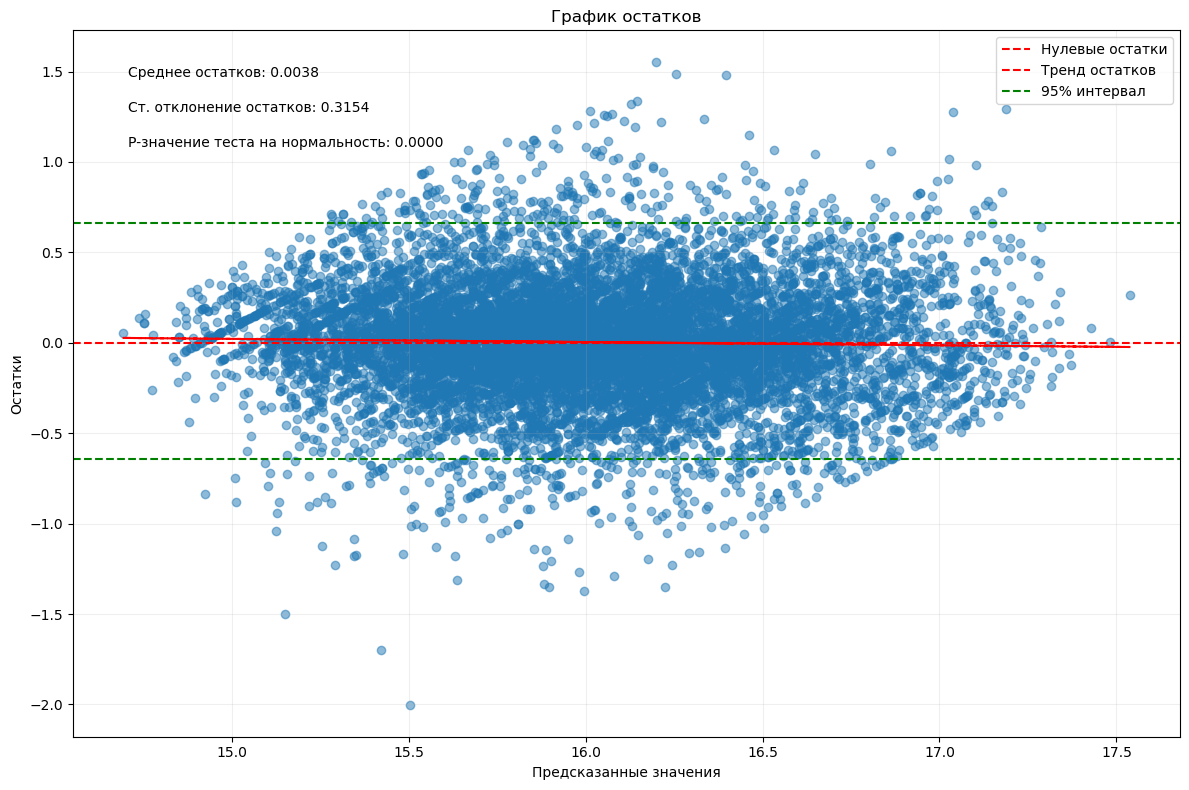

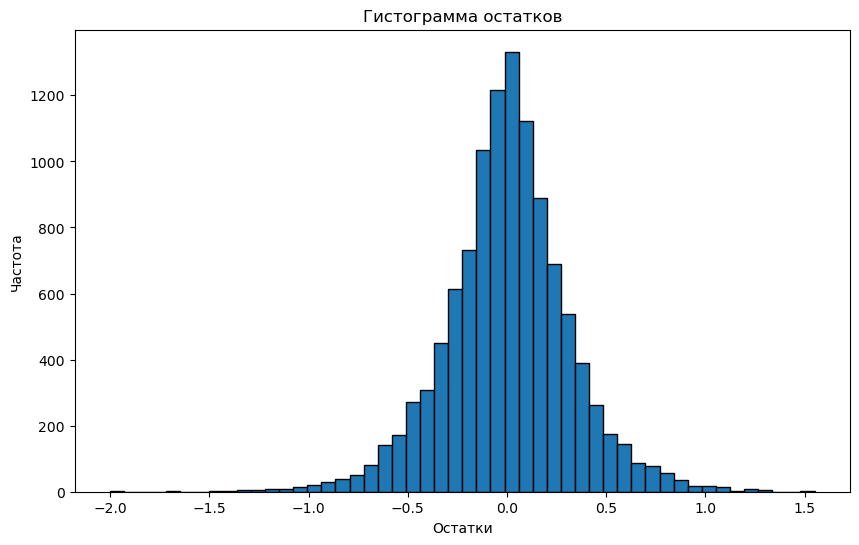

In [14]:
# График остатков RU

from scipy import stats

# Вычисляем остатки
residuals = y_pred_ru - y_true_ru

# Создаем график
fig, ax = plt.subplots(figsize=(12, 8))

# Основной график остатков
ax.scatter(y_pred_ru, residuals, alpha=0.5)

# Добавляем линию нулевых остатков
ax.axhline(y=0, color='r', linestyle='--', label='Нулевые остатки')

# Добавляем линию тренда остатков
z = np.polyfit(y_pred_ru, residuals, 1)
p = np.poly1d(z)
ax.plot(y_pred_ru, p(y_pred_ru), "r--", label='Тренд остатков')

# Добавляем границы для 95% остатков
percentiles = np.percentile(residuals, [2.5, 97.5])
ax.axhline(y=percentiles[0], color='g', linestyle='--', label='95% интервал')
ax.axhline(y=percentiles[1], color='g', linestyle='--')

# Настройка осей
ax.set_xlabel("Предсказанные значения")
ax.set_ylabel("Остатки")
ax.set_title("График остатков")

# Добавляем дополнительную информацию
ax.text(0.05, 0.95, f'Среднее остатков: {np.mean(residuals):.4f}', transform=ax.transAxes, verticalalignment='top')
ax.text(0.05, 0.90, f'Ст. отклонение остатков: {np.std(residuals):.4f}', transform=ax.transAxes, verticalalignment='top')

# Проверка на нормальность распределения остатков
_, p_value = stats.normaltest(residuals)
ax.text(0.05, 0.85, f'P-значение теста на нормальность: {p_value:.4f}', transform=ax.transAxes, verticalalignment='top')

# Добавляем легенду
ax.legend()

# Добавляем сетку для удобства чтения
ax.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

# Добавим гистограмму остатков
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='black')
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

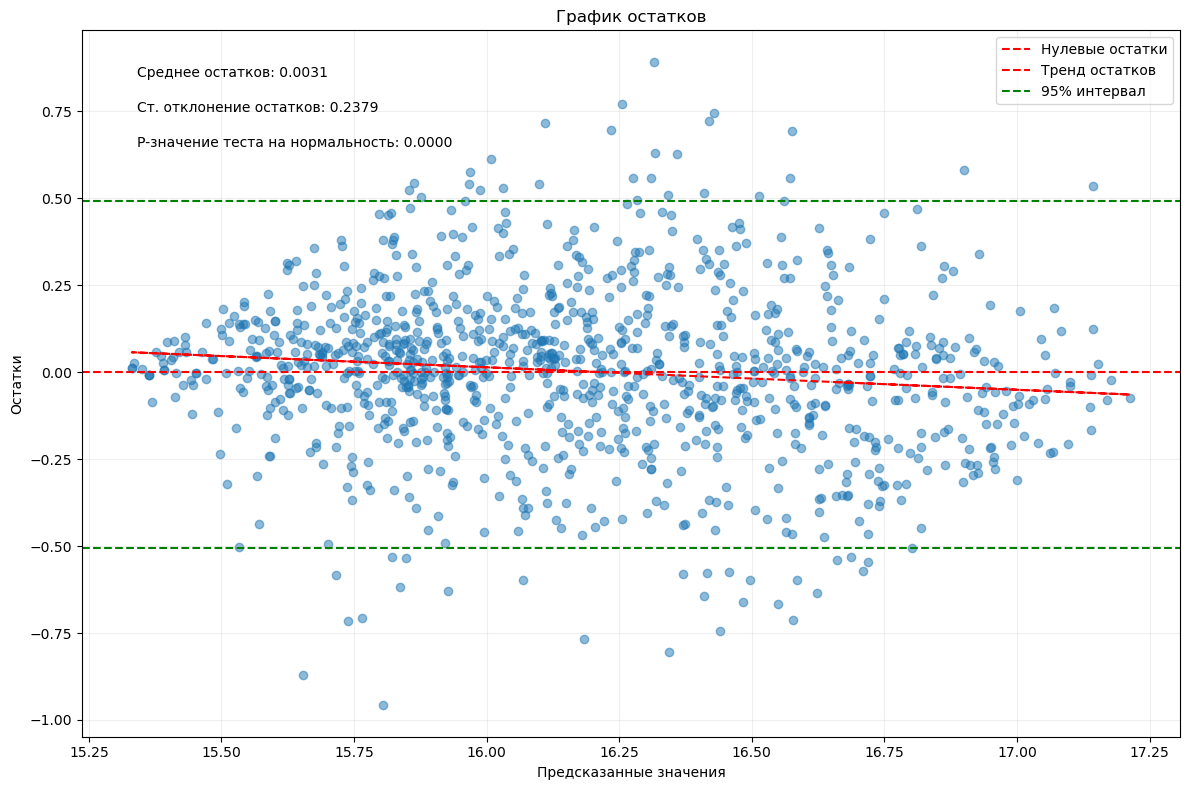

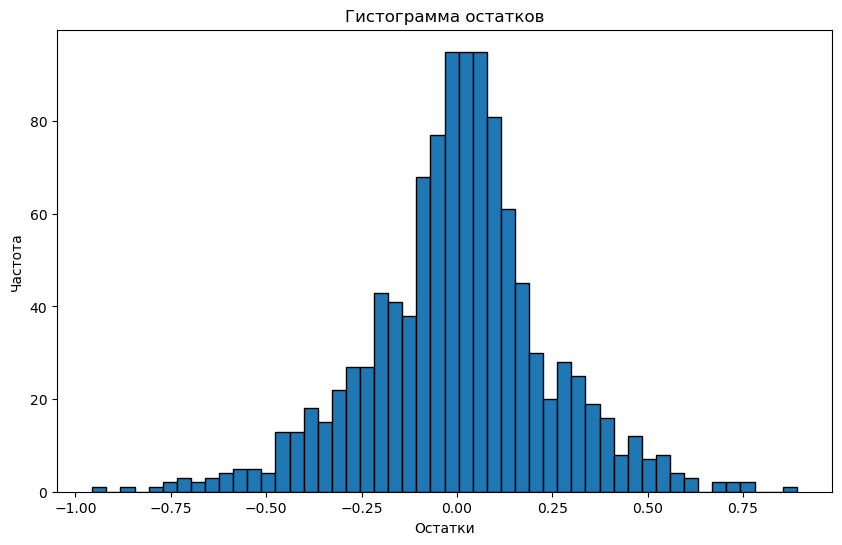

In [15]:
# График остатков MSK

from scipy import stats

# Вычисляем остатки
residuals = y_pred_msk - y_true_msk

# Создаем график
fig, ax = plt.subplots(figsize=(12, 8))

# Основной график остатков
ax.scatter(y_pred_msk, residuals, alpha=0.5)

# Добавляем линию нулевых остатков
ax.axhline(y=0, color='r', linestyle='--', label='Нулевые остатки')

# Добавляем линию тренда остатков
z = np.polyfit(y_pred_msk, residuals, 1)
p = np.poly1d(z)
ax.plot(y_pred_msk, p(y_pred_msk), "r--", label='Тренд остатков')

# Добавляем границы для 95% остатков
percentiles = np.percentile(residuals, [2.5, 97.5])
ax.axhline(y=percentiles[0], color='g', linestyle='--', label='95% интервал')
ax.axhline(y=percentiles[1], color='g', linestyle='--')

# Настройка осей
ax.set_xlabel("Предсказанные значения")
ax.set_ylabel("Остатки")
ax.set_title("График остатков")

# Добавляем дополнительную информацию
ax.text(0.05, 0.95, f'Среднее остатков: {np.mean(residuals):.4f}', transform=ax.transAxes, verticalalignment='top')
ax.text(0.05, 0.90, f'Ст. отклонение остатков: {np.std(residuals):.4f}', transform=ax.transAxes, verticalalignment='top')

# Проверка на нормальность распределения остатков
_, p_value = stats.normaltest(residuals)
ax.text(0.05, 0.85, f'P-значение теста на нормальность: {p_value:.4f}', transform=ax.transAxes, verticalalignment='top')

# Добавляем легенду
ax.legend()

# Добавляем сетку для удобства чтения
ax.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

# Добавим гистограмму остатков
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='black')
plt.title('Гистограмма остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

Top 20 объектов с наибольшей ошибкой:
          error  Площ.дома  Площ.Участка  Санузел  МатериалСтен  Кол-воЭтаж  \
55328  2.000713      100.0           7.5      1.0     15.741609         1.0   
19822  1.696141      154.0          15.0      1.0     16.052489         2.0   
4196   1.550350      151.5           4.4      1.0     16.052489         2.0   
71462  1.498204      150.0          10.0      1.0     16.060328         1.0   
4876   1.485394      226.0          10.0      1.0     16.052489         2.0   
22099  1.482222      150.0           5.0      1.0     16.075461         1.0   
55541  1.374706      120.0          10.0      1.0     15.724329         2.0   
55102  1.351952      250.0           6.0      1.0     16.060328         2.0   
23958  1.350805      278.0          15.0      1.0     16.060328         3.0   
3338   1.337272      133.0           9.0      1.0     16.060328         3.0   
18085  1.334204      200.0           5.7      1.0     16.060328         2.0   
4381   1.31975

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


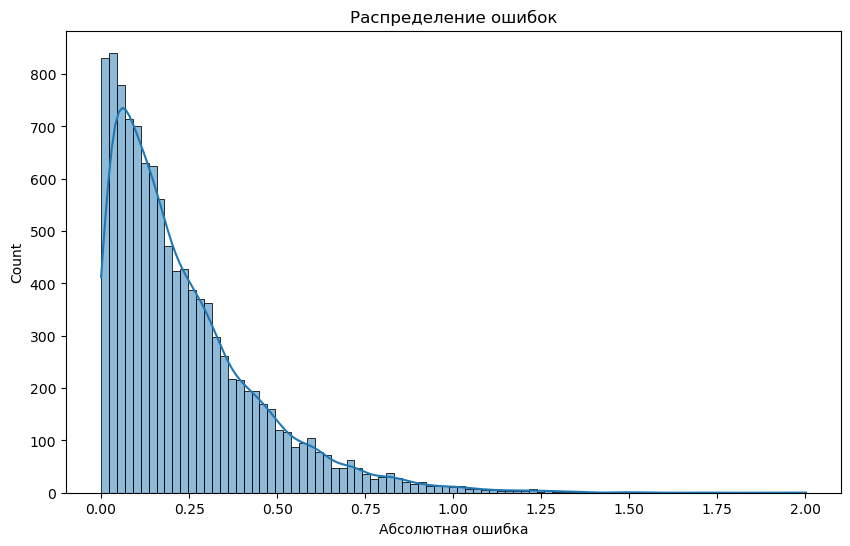


Корреляция ошибки с числовыми признаками:
error                                1.000000
Площ.дома                            0.136402
Кол-воКомн_encoded                   0.126294
Площ.Участка                         0.122168
Кол-воЭтаж                           0.116775
Есть_баня                            0.101669
Санузел                              0.088642
Возраст_Modern (10-20 years)         0.078732
Есть_гараж                           0.077148
Расст_центр_Нет данных               0.063701
log_price                            0.060494
Возраст_Recent (5-10 years)          0.053368
Возраст_Established (20-40 years)    0.049107
Есть_бассейн                         0.047180
Свободная_планировка                 0.041678
Есть_tv                              0.037836
Возраст_Old (40+ years)              0.025960
Есть_асфальт                         0.020401
Есть_wifi                            0.013005
ВозрастДома                         -0.001153
ВозрастДома_Squared                 -

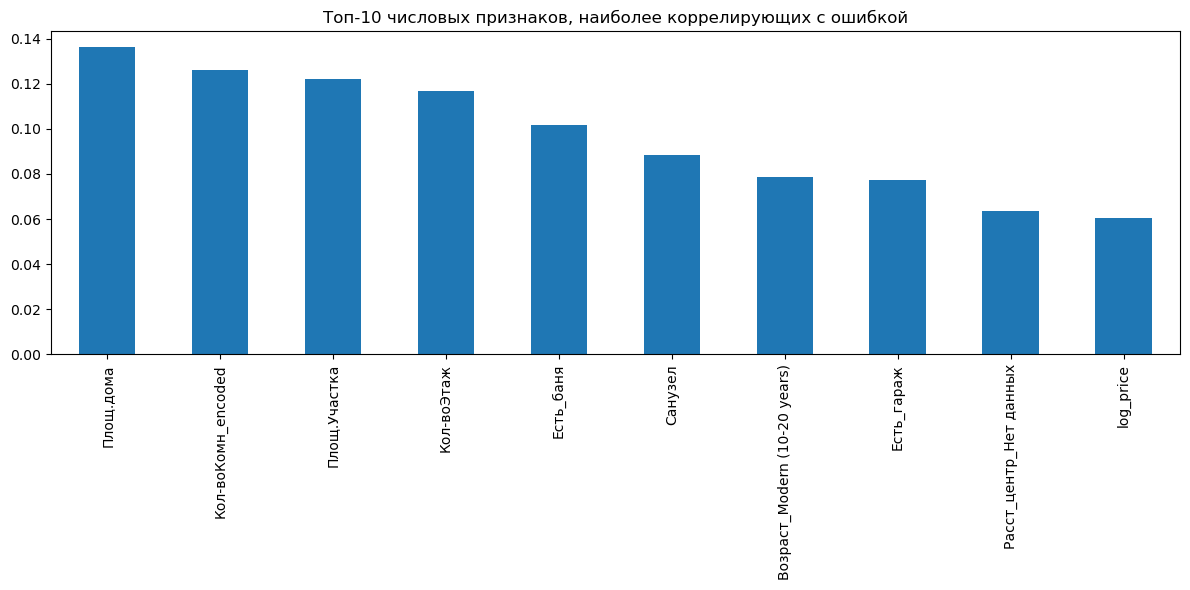

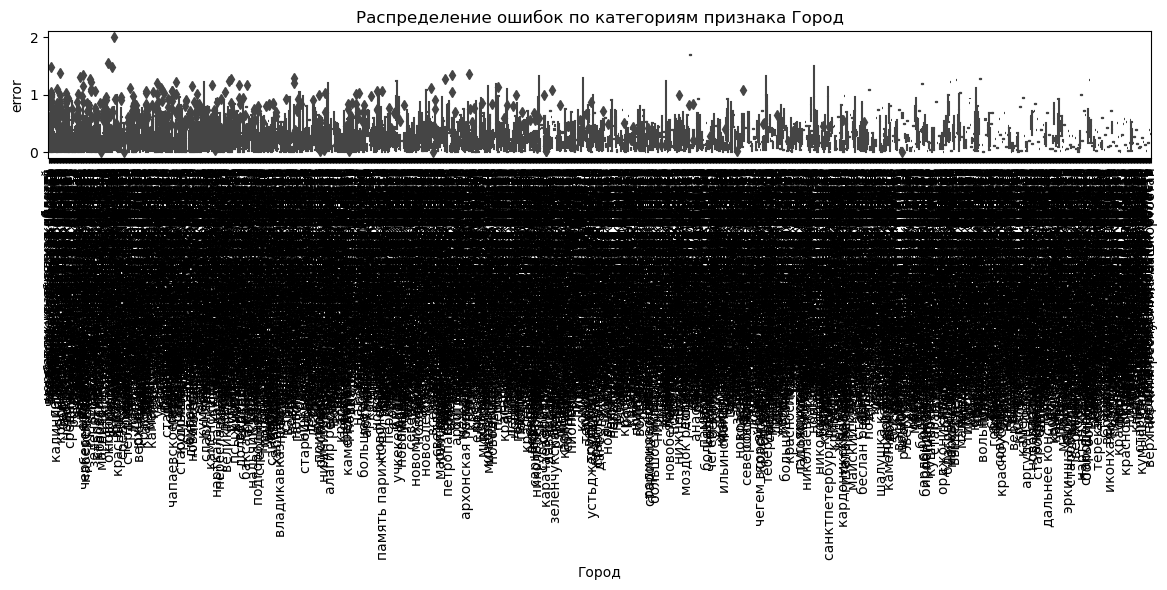


Среднее значение ошибки для каждой категории признака Город:
Город
печоры псковская область              1.696141
медведево республика марий эл         1.267315
глебычево ленинградская область       1.257696
борисоглебский ярославская область    1.252635
каз кемеровская область               1.227818
                                        ...   
октябрьское челябинская область       0.002820
ворсма нижегородская область          0.002775
глинищево брянская область            0.001692
гидроторф нижегородская область       0.001391
грамотеино кемеровская область        0.000574
Name: error, Length: 1483, dtype: float64


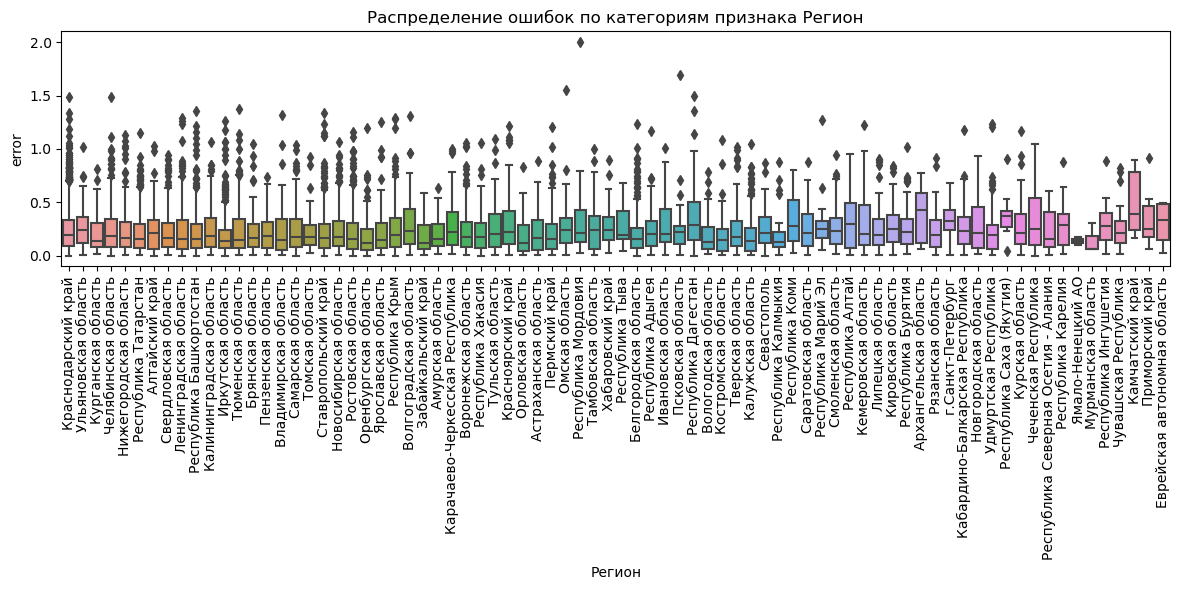


Среднее значение ошибки для каждой категории признака Регион:
Регион
Камчатский край             0.496472
Республика Саха (Якутия)    0.382770
Архангельская область       0.382183
Республика Мордовия         0.370307
Приморский край             0.357630
                              ...   
Костромская область         0.184443
Иркутская область           0.183800
Оренбургская область        0.169531
Мурманская область          0.141756
Ямало-Ненецкий АО           0.134883
Name: error, Length: 78, dtype: float64


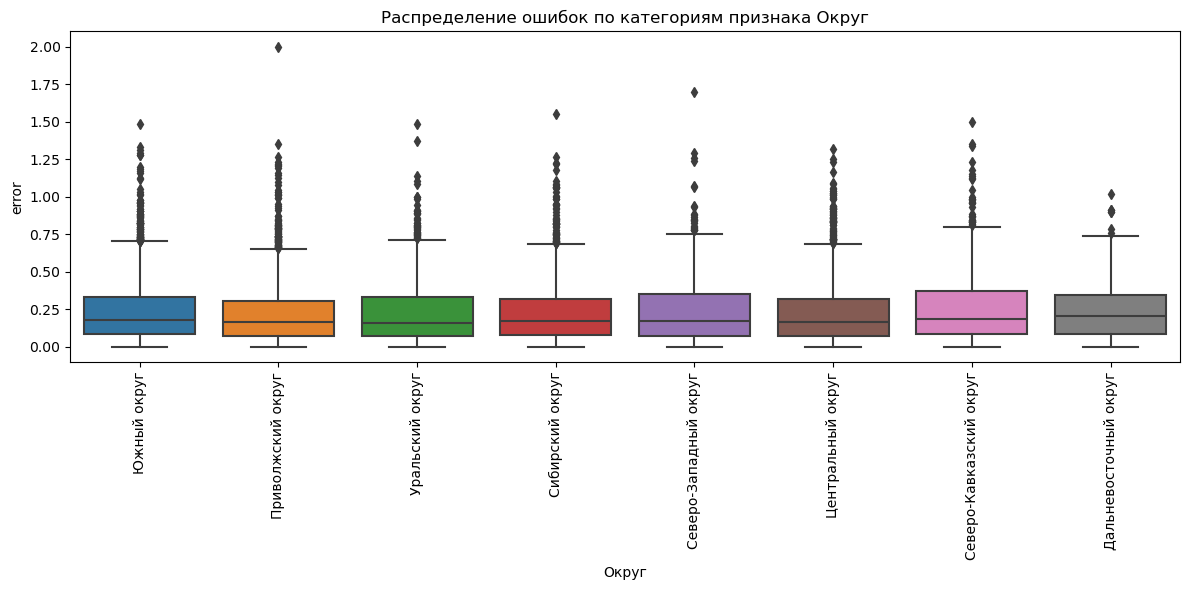


Среднее значение ошибки для каждой категории признака Округ:
Округ
Северо-Кавказский округ    0.258418
Дальневосточный округ      0.256753
Северо-Западный округ      0.245167
Южный округ                0.234865
Центральный округ          0.234863
Сибирский округ            0.232542
Уральский округ            0.231464
Приволжский округ          0.219588
Name: error, dtype: float64
Top 20 объектов с наибольшей ошибкой:
         error  Площ.дома  Площ.Участка  Санузел  Расстояние от МКАД  \
7983  0.955872      125.0          15.0      1.0                67.0   
292   0.891048      144.0          10.0      1.0                26.0   
8399  0.870386       91.7           5.8      1.0                28.0   
6292  0.803801      120.0          13.0      1.0                52.0   
582   0.772674      180.0          10.5      1.0                48.0   
8043  0.768130      110.0           5.0      1.0                24.0   
113   0.744480      176.0           3.0      1.0                 8.0   
66

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


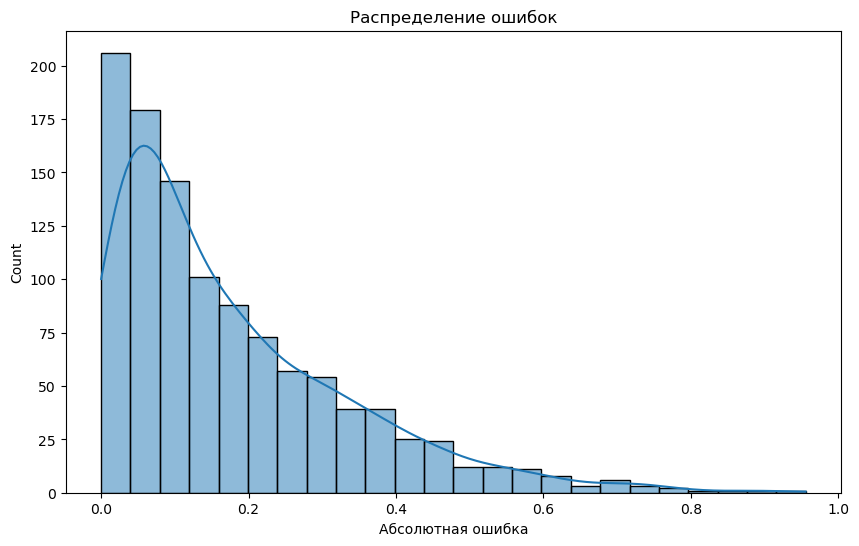


Корреляция ошибки с числовыми признаками:
error                                1.000000
log_price                            0.129598
Площ.Участка                         0.124825
Есть_гараж                           0.110079
Возраст_Recent (5-10 years)          0.093046
Возраст_Modern (10-20 years)         0.084733
Есть_баня                            0.080429
МатериалСтен                         0.075130
Площ.дома                            0.069014
Кол-воЭтаж                           0.045266
Есть_отопление                       0.037880
Есть_tv                              0.028125
Свободная_планировка                 0.024342
Есть_бассейн                         0.021408
Возраст_Established (20-40 years)    0.018913
Кол-воКомн_encoded                   0.017034
Расстояние от МКАД                   0.010562
Есть_wifi                            0.009247
Санузел                              0.005380
ВозрастДома                         -0.016868
ВозрастДома_Squared                 -

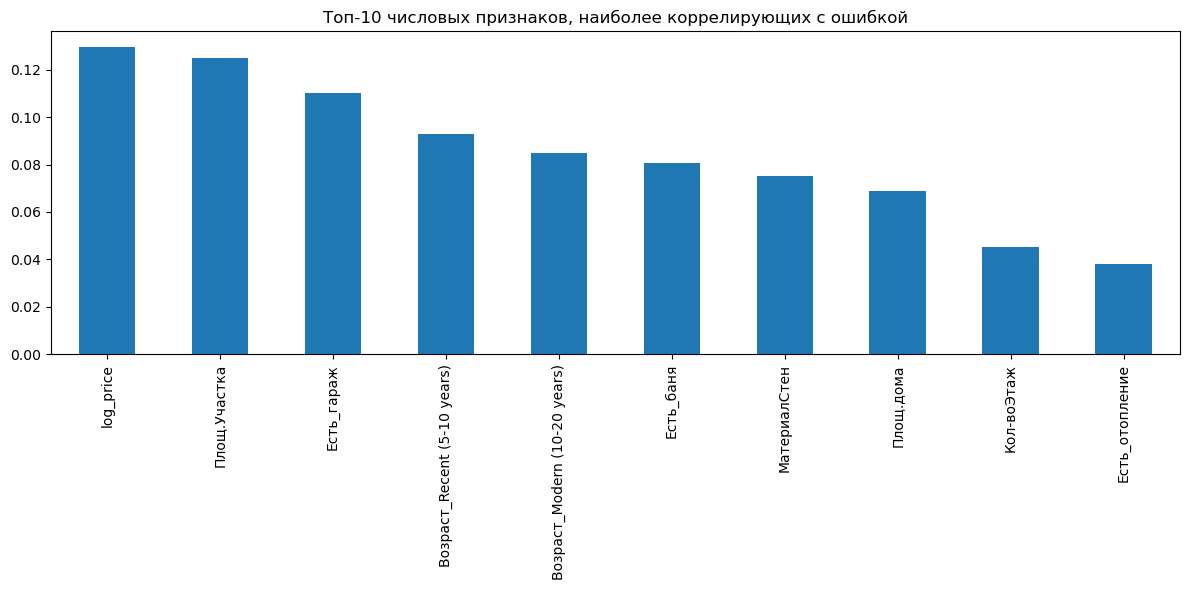

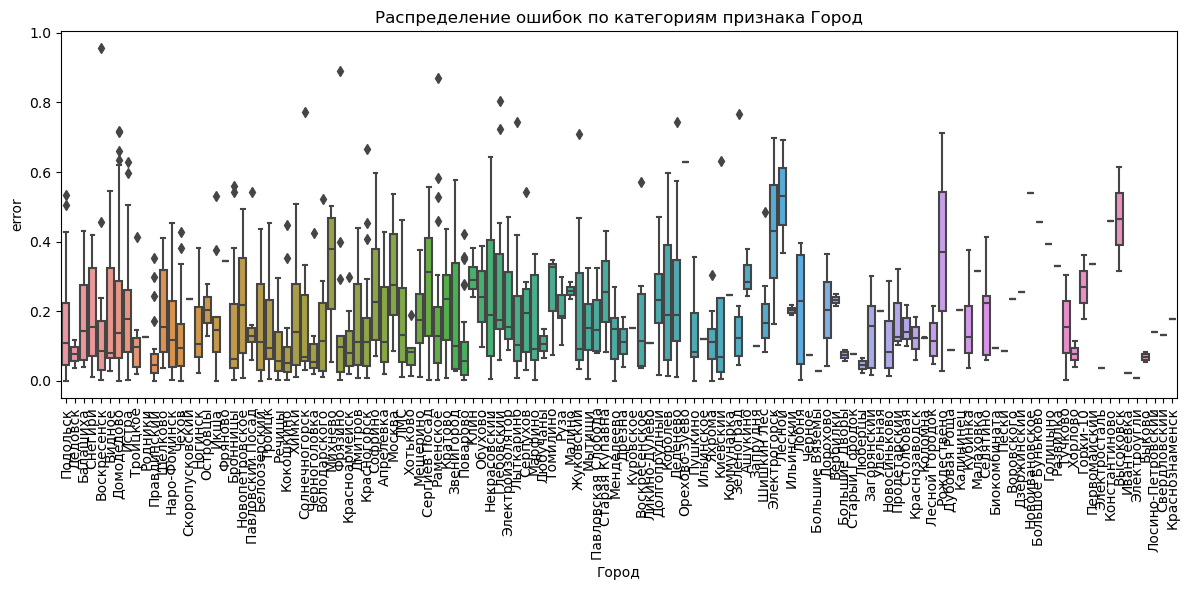


Среднее значение ошибки для каждой категории признака Город:
Город
Орехово-Зуево     0.630118
Новоивановское    0.538825
Лесной            0.530338
Высоковск         0.465172
Константиново     0.458397
                    ...   
Люберцы           0.045125
Электросталь      0.037465
Большие Вяземы    0.027443
Ивантеевка        0.023249
Электроугли       0.009675
Name: error, Length: 126, dtype: float64


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_large_errors(y_true, y_pred, X, n_top=20):
    """
    Анализирует объекты с наибольшей ошибкой предсказания.
    
    :param y_true: фактические значения
    :param y_pred: предсказанные значения
    :param X: датафрейм с признаками
    :param n_top: количество объектов с наибольшей ошибкой для анализа
    """
    # Вычисляем абсолютную ошибку
    errors = np.abs(y_true - y_pred)
    
    # Создаем датафрейм с ошибками и всеми признаками
    error_df = pd.concat([pd.Series(errors, name='error'), X], axis=1)
    
    # Сортируем по убыванию ошибки
    error_df_sorted = error_df.sort_values('error', ascending=False)
    
    # Выбираем top n объектов с наибольшей ошибкой
    top_errors = error_df_sorted.head(n_top)
    
    print(f"Top {n_top} объектов с наибольшей ошибкой:")
    print(top_errors)
    
    # Визуализация распределения ошибок
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True)
    plt.title("Распределение ошибок")
    plt.xlabel("Абсолютная ошибка")
    plt.show()
    
    # Анализ корреляции ошибок с числовыми признаками
    numeric_columns = error_df.select_dtypes(include=[np.number]).columns
    numeric_columns = numeric_columns.drop('error') if 'error' in numeric_columns else numeric_columns
    
    if len(numeric_columns) > 0:
        corr = error_df[['error'] + list(numeric_columns)].corr()['error'].sort_values(ascending=False)
        print("\nКорреляция ошибки с числовыми признаками:")
        print(corr)
        
        # Визуализация топ-10 признаков, наиболее коррелирующих с ошибкой
        plt.figure(figsize=(12, 6))
        corr.drop('error').nlargest(10).plot(kind='bar')
        plt.title("Топ-10 числовых признаков, наиболее коррелирующих с ошибкой")
        plt.tight_layout()
        plt.show()
    
    # Анализ категориальных признаков
    cat_columns = X.select_dtypes(include=['object', 'category']).columns
    for col in cat_columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=col, y='error', data=error_df)
        plt.title(f"Распределение ошибок по категориям признака {col}")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
        
        # Среднее значение ошибки для каждой категории
        mean_errors = error_df.groupby(col)['error'].mean().sort_values(ascending=False)
        print(f"\nСреднее значение ошибки для каждой категории признака {col}:")
        print(mean_errors)

# Пример использования
analyze_large_errors(y_true_ru, y_pred_ru, test_ru, n_top=20)
analyze_large_errors(y_true_msk, y_pred_msk, test_msk, n_top=20)